In [ ]:
pip install wandb datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-7ff90ww0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-7ff90ww0
  Resolved https://github.com/huggingface/accelerate to commit 7d24bdefb5b3252505151d8c1ac0efbed3574857
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define the dataset class for custom data
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, padding=True, truncation=True)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/IndicBART")

In [ ]:
import pandas as pd

df = pd.read_csv('corrected_data.csv')

,labels
0,19514
1,18521


1.0536148156147076 : 1


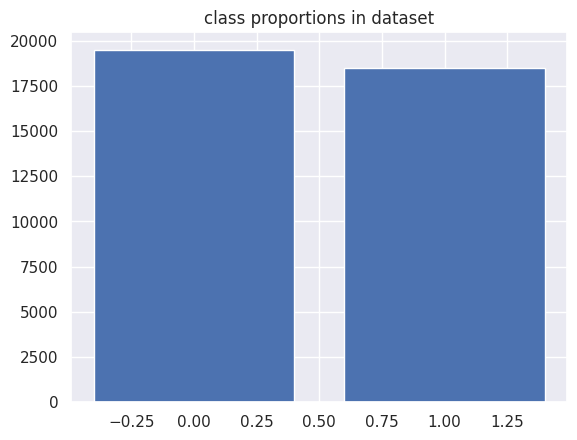

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

display(df['labels'].value_counts().to_frame())
print(df['labels'].value_counts()[0]/df['labels'].value_counts()[1].round(2),": 1")
plt.bar([0,1],df['labels'].value_counts())
plt.title("class proportions in dataset")
plt.savefig('indic-bert.png')

In [ ]:
df = df.sample(frac=1, random_state=42)
df.head()

,Content,labels
15475,ఎల్లి అల్లు అర్జున్ గది పుకు నాకు,1
8170,అవును నీ అమ్మ నీ దెంగినప్పుడు అదే నటన కదా రా...,1
20780,సంతోషం గుర్తు వున్నా అందుకే ఎలా వున్నావు కన...,0
31775,ఎంఐ వాళ్లకి వాడి పైనా ఉన్నా కాన్ఫిడెన్స్ ఏంట...,0
30161,మంచి మావ్స్ నువ్వు ఎలా వున్నావు,0


In [ ]:
# Define the custom data
texts = list(df['Content'])
labels = list(df['labels'])

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(texts,labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state=42)

In [ ]:
# Create the dataset and dataloader for custom data
train_dataset = CustomDataset(x_train, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Create the dataset and dataloader for custom data
val_dataset = CustomDataset(x_val, y_val, tokenizer)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Create the dataset and dataloader for custom data
test_dataset = CustomDataset(x_test, y_test, tokenizer)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# Load the transformer model and remove the decoder layer
transformer_model = AutoModel.from_pretrained("ai4bharat/IndicBART")
transformer_model.resize_token_embeddings(len(tokenizer))
transformer_model = transformer_model.encoder

Some weights of the model checkpoint at ai4bharat/IndicBART were not used when initializing MBartModel: ['lm_head.weight', 'final_logits_bias']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Add the sequence classification head for fine-tuning
classifier = torch.nn.Linear(transformer_model.config.hidden_size, 2)
transformer_model.sequence_classifier = classifier

In [ ]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Fine-tune the model on custom data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model.to(device)

MBartEncoder(
  (embed_tokens): Embedding(64014, 1024, padding_idx=0)
  (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
  (layers): ModuleList(
    (0-5): 6 x MBartEncoderLayer(
      (self_attn): MBartAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (layer_norm): LayerNorm((1024,), eps

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

scaler = torch.cuda.amp.GradScaler() # initialize the gradient scaler

for epoch in range(3):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    optimizer.zero_grad()

    # Training loop
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast(): # enable mixed precision training
            outputs = transformer_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = transformer_model.sequence_classifier(outputs[0][:, 0, :])
            loss = loss_fn(logits, labels)

        scaler.scale(loss).backward() # scale the loss before backpropagation

        if (i+1) % 8 == 0: # accumulate gradients every 8 batches
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(logits, dim=1).tolist())
        train_labels.extend(labels.tolist())

    train_loss /= len(train_loader)
    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_precision = precision_score(train_labels, train_preds, average='macro')
    train_recall = recall_score(train_labels, train_preds, average='macro')
    train_acc = accuracy_score(train_labels, train_preds)

    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Train F1 Score: {train_f1:.3f}')
    print(f'Train Precision: {train_precision:.3f}')
    print(f'Train Recall: {train_recall:.3f}')
    print(f'Train Accuracy: {train_acc:.3f}')

    # Validation loop
    val_loss = 0.0
    val_preds = []
    val_labels = []

    transformer_model.eval() # set the model to evaluation mode

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = transformer_model(input_ids=input_ids, attention_mask=attention_mask)
            logits = transformer_model.sequence_classifier(outputs[0][:, 0, :])
            loss = loss_fn(logits, labels)

            val_loss += loss.item()
            val_preds.extend(torch.argmax(logits, dim=1).tolist())
            val_labels.extend(labels.tolist())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_precision = precision_score(val_labels, val_preds, average='macro')
    val_recall = recall_score(val_labels, val_preds, average='macro')
    val_acc = accuracy_score(val_labels, val_preds)

    print(f'Validation Loss: {val_loss:.3f}')
    print(f'Validation F1 Score: {val_f1:.3f}')
    print(f'Validation Precision: {val_precision:.3f}')
    print(f'Validation Recall: {val_recall:.3f}')
    print(f'Validation Accuracy: {val_acc:.3f}')

    transformer_model.train() # set the model back to training mode

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1
Train Loss: nan
Train F1 Score: 0.339
Train Precision: 0.257
Train Recall: 0.500
Train Accuracy: 0.513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.693
Validation F1 Score: 0.339
Validation Precision: 0.257
Validation Recall: 0.500
Validation Accuracy: 0.513


Epoch 2
Train Loss: nan
Train F1 Score: 0.340
Train Precision: 0.507
Train Recall: 0.500
Train Accuracy: 0.513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.693
Validation F1 Score: 0.339
Validation Precision: 0.257
Validation Recall: 0.500
Validation Accuracy: 0.513


Epoch 3
Train Loss: nan
Train F1 Score: 0.340
Train Precision: 0.493
Train Recall: 0.500
Train Accuracy: 0.513


Validation Loss: 0.693
Validation F1 Score: 0.339
Validation Precision: 0.257
Validation Recall: 0.500
Validation Accuracy: 0.513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

test_preds = []
test_labels = []

transformer_model.eval() # set the model to evaluation mode

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = transformer_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = transformer_model.sequence_classifier(outputs[0][:, 0, :])

        test_preds.extend(torch.argmax(logits, dim=1).tolist())
        test_labels.extend(labels.tolist())


In [ ]:

# Calculate metrics
test_f1 = f1_score(test_labels, test_preds, average='macro')
# test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_acc = accuracy_score(test_labels, test_preds)
test_cm = confusion_matrix(test_labels, test_preds)
test_roc_auc = roc_auc_score(test_labels, test_preds)


In [ ]:

# Print metrics
print(f'Test F1 Score: {test_f1:.3f}')
print(f'Test Precision: {test_precision:.3f}')
print(f'Test Recall: {test_recall:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')
print(f'Test Confusion Matrix:\n{test_cm}')
print(f'Test ROC-AUC Score: {test_roc_auc:.3f}')


Test F1 Score: 0.339
Test Precision: 0.257
Test Recall: 0.500
Test Accuracy: 0.513
Test Confusion Matrix:
[[12490     0]
 [11852     0]]
Test ROC-AUC Score: 0.500


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 9>:9                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'classes' is not defined

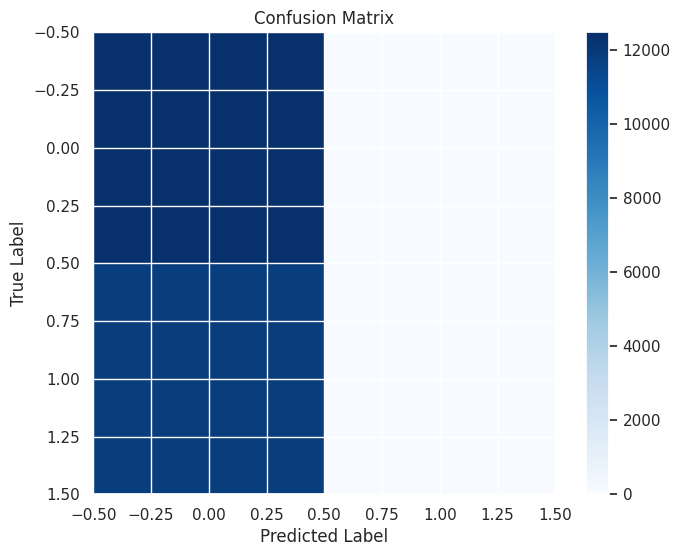

In [ ]:
import numpy as np
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.show()


In [ ]:

# Plot ROC-AUC Curve
test_probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy() # get probabilities for positive class
fpr, tpr, _ = roc_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:992 in roc_curve             │
│                                                                                                  │
│    989 │   >>> thresholds                                                                        │
│    990 │   array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])                                                 │
│    991 │   """                                                                                   │
│ ❱  992 │   fps, tps, thresholds = _binary_clf_curve(                                             │
│    993 │   │   y_true, y_score, pos_label=pos_label, sample_weight=sample_weight                 │
│    994 │   )                                                                                     │
│    995                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:751 in _binary_clf_curve     │
│                                                                                                  │
│    748 │   if not (y_type == "binary" or (y_type == "multiclass" and pos_label is not None)):    │
│    749 │   │   raise ValueError("{0} format is not supported".format(y_type))                    │
│    750 │                                                                                         │
│ ❱  751 │   check_consistent_length(y_true, y_score, sample_weight)                               │
│    752 │   y_true = column_or_1d(y_true)                                                         │
│    753 │   y_score = column_or_1d(y_score)                                                       │
│    754 │   assert_all_finite(y_true)                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:397 in                       │
│ check_consistent_length                                                                          │
│                                                                                                  │
│    394 │   lengths = [_num_samples(X) for X in arrays if X is not None]                          │
│    395 │   uniques = np.unique(lengths)                                                          │
│    396 │   if len(uniques) > 1:                                                                  │
│ ❱  397 │   │   raise ValueError(                                                                 │
│    398 │   │   │   "Found input variables with inconsistent numbers of samples: %r"              │
│    399 │   │   │   % [int(l) for l in lengths]                                                   │
│    400 │   │   )                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Found input variables with inconsistent numbers of samples: [24342, 22]

In [ ]:
torch.save(transformer_model.state_dict(), 'Indicbart_Tel/indicbart_model.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Example code for loading and using the nllb model for sequence classification

In [ ]:
from transformers import NLLBModel, NLLBTokenizer

# Initialize the model architecture
transformer_model = NLLBModel.from_pretrained('')

# Load the saved model state dictionary
transformer_model.load_state_dict(torch.load('NLLB_Tel/nllb_model.pth'))

# Initialize other components (tokenizer, optimizer, etc.) as needed

# Use the model for inference or continue training
